# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import os
import glob
import re
from colour import Color
from matplotlib.colors import LinearSegmentedColormap

# Configure matplotlib
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Suppress warnings
warnings.filterwarnings('ignore')


def make_colormap(colors, show_palette=False):
    """Create a custom colormap from a list of colors."""
    color_ramp = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors])
    if show_palette:
        plt.figure(figsize=(15, 3))
        plt.imshow([list(np.arange(0, len(colors), 0.1))], interpolation='nearest', origin='lower', cmap=color_ramp)
        plt.xticks([])
        plt.yticks([])
    return color_ramp


def reject_outliers(data, m=2):
    """Remove outliers from data based on standard deviation."""
    return data[abs(data - np.mean(data)) < m * np.std(data)]


def rgb2hex(vals, rgbtype=1):
    """Convert RGB values to hex color codes.
    
    Args:
        vals: RGB/RGBA tuple
        rgbtype: 1 for 0-1 range, 256 for 0-255 range
    
    Returns:
        Hex string in format '#RRGGBB' or '#RRGGBBAA'
    """
    if len(vals) not in [3, 4]:
        raise Exception("RGB or RGBA inputs must have three or four elements!")
    if rgbtype not in [1, 256]:
        raise Exception("rgbtype must be 1 or 256!")

    # Convert from 0-1 RGB/RGBA to 0-255 RGB/RGBA
    if rgbtype == 1:
        vals = [255 * x for x in vals]

    # Ensure values are rounded integers, convert to hex, and concatenate
    return '#' + ''.join(['{:02X}'.format(int(round(x))) for x in vals])

def create_color_map(colors):
    """Create a LinearSegmentedColormap from color list."""
    return LinearSegmentedColormap.from_list('custom_map', colors)


def get_color_ranks(values):
    """Get normalized color ranks for values."""
    ranks = values.rank(ascending=False)
    normalized_ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())
    return 1 - np.power(normalized_ranks, 0.7)

# Color palettes for different metrics
metric_overall_colormap = ['#2D203E', '#704774', '#B77D9F', '#E0B3BD', '#F4E2E1']
metric_sample_colormap = ['#0A1D58', '#235FA8', '#40B6C4', '#C7E9B4', '#FDFFAB']
metric_bio_colormap = ['#49006A', '#AE007E', '#F768A1', '#FCC5C0', '#FFE9DE']
metric_batch_colormap = ['#4D004A', '#88419D', '#8C96C6', '#BFD3E6', '#CEF5FD']
metric_modality_colormap = ['#390099', '#9381ff', '#b8b8ff', '#d0d0fc', '#f8f7ff']
metric_continuity_colormap = ['#8c2104', '#f93f06', '#ff6b35', '#f7c59f', '#ffe8dc']
metric_marker_colormap = ['#002D4F', '#6BB0ED', '#92CCF7', '#B1D8FC', '#E1EDF9']
metric_reconstruction_colormap = ['#081c15', '#2d6a4f', '#52b788', '#95d5b2', '#d8f3dc']
metric_time_colormap = ['#000000', '#4d4d4d', '#999999', '#cccccc', '#ffffff']

# Color dictionary mapping
color_dict = {
    'total_score': metric_overall_colormap,
    'continuity': metric_continuity_colormap,
    'marker_score': metric_marker_colormap,
    'reconstruction': metric_reconstruction_colormap,
    'biological_conservation': metric_bio_colormap,
    'batch_correction': metric_batch_colormap,
    'cross_sample': metric_sample_colormap,
    'cross_modality': metric_modality_colormap,
    'time_memory': metric_time_colormap
}

# Method color mapping
method_color_dict = {
    "spatialMETA": "#8873a4",
    "spatialGLUE": "#beb1d6",
    "spaVAE": "#a2cbec",
    "spaMultiVAE": "#16a9ca",
    "scVI": "#f4afc1",
    "scANVI": "#e17492",
    "totalVI": "#9e365c",
    "scPoli": "#f7c770",
    "Stabmap": "#8b97ab",
    "Seurat RPCA": "#189067",
    "Seurat CCA": "#5cbc93",
    "SeuratV5_BNN": "#c0dfb6",
    "PCA": "#c8d0c4",
    "MISO": "#C88EA7"
}

# Method name conversion dictionary
convert_dict = {  
    'totalvi':'totalVI',   
    'scvi':'scVI',   
    'scpoli':'scPoli',   
    'pca':'PCA',   
    'scanvi':'scANVI',   
    'spatialmeta':'spatialMETA',   
    'spavae':'spaVAE',   
    'seurat_rpca':'Seurat RPCA',   
    'seurat_cca':'Seurat CCA'  
}  

/home/snow/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Read table and preprocess

In [2]:
import pandas as pd
import numpy as np
from itertools import combinations

In [3]:
#sample_chosen = "mouse_brain"
sample_chosen = "RCC_M1"
df = pd.read_csv(f"/mnt/volume0/cyr_qyc/qyc/cross_sample/results_new/benchmark/index/merge_adata_{sample_chosen}_svf_bench_sample_mean_merged.csv")

In [4]:
df['all_mean_score'] = df.drop(['method', 'time', 'memory'], axis=1).mean(axis=1, skipna=True)

In [5]:
df.columns

Index(['method', 'batch_asw', 'ilisi_graph', 'pcr', 'ARI', 'NMI',
       'isolated_asw', 'clisi_graph', 'gt_silhouette', 'CHAOS', 'PAS', 'ASW',
       'ST_moranI_top5', 'ST_gearyC_top5', 'ST_moranI_top10',
       'ST_gearyC_top10', 'ST_moranI_top20', 'ST_gearyC_top20',
       'ST_moranI_top50', 'ST_gearyC_top50', 'ST_moranI_top100',
       'ST_gearyC_top100', 'ST_moranI_top200', 'ST_gearyC_top200',
       'ST_moranI_top500', 'ST_gearyC_top500', 'SM_moranI_top5',
       'SM_gearyC_top5', 'SM_moranI_top10', 'SM_gearyC_top10',
       'SM_moranI_top20', 'SM_gearyC_top20', 'SM_moranI_top50',
       'SM_gearyC_top50', 'SM_moranI_top100', 'SM_gearyC_top100',
       'SM_moranI_top200', 'SM_gearyC_top200', 'SM_specificity_thresh100',
       'ST_specificity_thresh100', 'SM_specificity_thresh99',
       'ST_specificity_thresh99', 'SM_specificity_thresh98',
       'ST_specificity_thresh98', 'SM_specificity_thresh95',
       'ST_specificity_thresh95', 'ST_logistic', 'SM_logistic', 'ST_mi',
       '

In [6]:
df.method = df.method.replace(convert_dict)

## Scale 0-1 

In [7]:
# the metrics need to 1-
for col in ['CHAOS', 'PAS']:
    if col in df.columns:
        df[col] = 1 - df[col]

In [8]:
from sklearn.preprocessing import MinMaxScaler
special_scale_cols = ['mean_pcc', 'mean_cos_sim']
for col in special_scale_cols:
    if col in df.columns:
        # Temporarily fill None with 0
        temp = df[col].copy()
        temp_filled = temp.fillna(0)
        # Scale to [0, 1]
        scaled = MinMaxScaler().fit_transform(temp_filled.values.reshape(-1, 1)).flatten()
        # Restore 0s to None (if they were originally None)
        scaled[temp.isna()] = np.nan
        df[col] = scaled

In [9]:
scale_cols = [
    'SM_specificity_thresh100', 'ST_specificity_thresh100', 'SM_specificity_thresh99',
    'ST_specificity_thresh99', 'SM_specificity_thresh98', 'ST_specificity_thresh98',
    'SM_specificity_thresh95', 'ST_specificity_thresh95', 'ST_logistic', 
    'SM_logistic', 'ST_mi', 'SM_mi'
]

for col in scale_cols:
    if col in df.columns:
        df[col] = MinMaxScaler().fit_transform(df[[col]])

## calculate the grouped df

In [10]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]
df_grouped = df_numeric.groupby(df['method']).mean()

In [11]:
df_grouped.loc[:,['time','memory']]

,time,memory
method,,
PCA,6.386066,2504.21
Seurat CCA,68.519712,2472.36
Seurat RPCA,62.688424,2673.77
scANVI,406.219695,3142.05
scPoli,376.634708,3392.33
scVI,323.078439,2881.42
spaVAE,77922.180000,4106.75
spatialMETA,196.589618,4380.98
totalVI,594.927903,4653.06


## Calculate the mean score for thresh or top

In [12]:
def calculate_mean_metrics(df):
    """Calculate mean metrics for columns with 'top' or 'thresh' patterns."""
    prefix_groups = {}
    for col in df.columns:
        match = re.match(r'(.+?)_(top|thresh)', col)
        if match:
            prefix = match.group(1)
            if prefix not in prefix_groups:
                prefix_groups[prefix] = []
            prefix_groups[prefix].append(col)
    
    for prefix, cols in prefix_groups.items():
        df[f'{prefix}_mean'] = df[cols].mean(axis=1)
    
    return df

In [13]:
df_mean = calculate_mean_metrics(df_grouped)

In [14]:
df_mean.columns

Index(['batch_asw', 'ilisi_graph', 'pcr', 'ARI', 'NMI', 'isolated_asw',
       'clisi_graph', 'gt_silhouette', 'CHAOS', 'PAS', 'ASW', 'ST_moranI_top5',
       'ST_gearyC_top5', 'ST_moranI_top10', 'ST_gearyC_top10',
       'ST_moranI_top20', 'ST_gearyC_top20', 'ST_moranI_top50',
       'ST_gearyC_top50', 'ST_moranI_top100', 'ST_gearyC_top100',
       'ST_moranI_top200', 'ST_gearyC_top200', 'ST_moranI_top500',
       'ST_gearyC_top500', 'SM_moranI_top5', 'SM_gearyC_top5',
       'SM_moranI_top10', 'SM_gearyC_top10', 'SM_moranI_top20',
       'SM_gearyC_top20', 'SM_moranI_top50', 'SM_gearyC_top50',
       'SM_moranI_top100', 'SM_gearyC_top100', 'SM_moranI_top200',
       'SM_gearyC_top200', 'SM_specificity_thresh100',
       'ST_specificity_thresh100', 'SM_specificity_thresh99',
       'ST_specificity_thresh99', 'SM_specificity_thresh98',
       'ST_specificity_thresh98', 'SM_specificity_thresh95',
       'ST_specificity_thresh95', 'ST_logistic', 'SM_logistic', 'ST_mi',
       'SM_mi', 't

## calculate the overall score

In [15]:
continuity_metrics = ['CHAOS', 'PAS']

# Simplified marker score metrics using mean values
marker_score_metrics = [
    'ST_moranI_mean', 'SM_moranI_mean', 
    'ST_gearyC_mean', 'SM_gearyC_mean',
    'ST_specificity_mean', 'SM_specificity_mean',
    'ST_logistic', 'SM_logistic', 
    'ST_mi', 'SM_mi'
]

biological_conservation_metrics = [
        'ARI', 'NMI', 'isolated_asw', 'clisi_graph',
       'gt_silhouette']

batch_correction_metrics = ["batch_asw", "ilisi_graph", "pcr"]

reconstruction_metrics = ["mean_pcc", "mean_cos_sim"]

scalability_metrics = ["time", "memory"]

cross_modality_metrics = ["continuity_mean","marker_score_mean","reconstruction_mean"]
cross_sample_metrics = ["biological_conservation_mean","batch_correction_mean"]

total_memtrics = ['cross_modality_mean','cross_sample_mean']

In [16]:
df_mean['continuity_mean'] = df_mean[continuity_metrics].mean(axis=1)
df_mean['marker_score_mean'] = df_mean[marker_score_metrics].mean(axis=1)
df_mean['biological_conservation_mean'] = df_mean[biological_conservation_metrics].mean(axis=1)
df_mean['batch_correction_mean'] = df_mean[batch_correction_metrics].mean(axis=1)
df_mean['reconstruction_mean'] = df_mean[reconstruction_metrics].mean(axis=1)
df_mean['cross_modality_mean'] = df_mean[cross_modality_metrics].mean(axis=1)
df_mean['cross_sample_mean'] = df_mean[cross_sample_metrics].mean(axis=1)

In [17]:
df_mean['total_score'] = df_mean[total_memtrics].mean(axis=1)

In [18]:
df_mean.loc[:,['continuity_mean','marker_score_mean','biological_conservation_mean','batch_correction_mean','reconstruction_mean',
               'cross_modality_mean','cross_sample_mean',"batch_asw", "ilisi_graph", "pcr",
               'total_score']]

,continuity_mean,marker_score_mean,biological_conservation_mean,batch_correction_mean,reconstruction_mean,cross_modality_mean,cross_sample_mean,batch_asw,ilisi_graph,pcr,total_score
method,,,,,,,,,,,
PCA,0.658128,0.319564,0.380235,0.322457,NaN,0.488846,0.351346,0.833836,0.133533,0.000000,0.420096
Seurat CCA,0.706391,0.517511,0.435919,0.762406,NaN,0.611951,0.599162,0.918310,0.465042,0.903865,0.605557
Seurat RPCA,0.745699,0.505051,0.470630,0.745174,NaN,0.625375,0.607902,0.916874,0.381582,0.937065,0.616638
scANVI,0.783096,0.429053,0.511346,0.667787,0.895509,0.702553,0.589566,0.891604,0.324031,0.787725,0.646059
scPoli,0.916615,0.576749,0.565767,0.546425,NaN,0.746682,0.556096,0.861381,0.065382,0.712511,0.651389
scVI,0.764872,0.389375,0.505590,0.702361,0.891427,0.681891,0.603975,0.894446,0.370355,0.842282,0.642933
spaVAE,0.667818,0.381041,0.485658,0.716131,0.940102,0.662987,0.600894,0.858940,0.478733,0.810720,0.631941
spatialMETA,0.831330,0.608274,0.534698,0.666674,1.000000,0.813201,0.600686,0.864417,0.265464,0.870142,0.706944
totalVI,0.851312,0.618233,0.566348,0.742148,0.318428,0.595991,0.654248,0.907183,0.340908,0.978353,0.625120


# Visualization

In [19]:
df_mean.columns

Index(['batch_asw', 'ilisi_graph', 'pcr', 'ARI', 'NMI', 'isolated_asw',
       'clisi_graph', 'gt_silhouette', 'CHAOS', 'PAS', 'ASW', 'ST_moranI_top5',
       'ST_gearyC_top5', 'ST_moranI_top10', 'ST_gearyC_top10',
       'ST_moranI_top20', 'ST_gearyC_top20', 'ST_moranI_top50',
       'ST_gearyC_top50', 'ST_moranI_top100', 'ST_gearyC_top100',
       'ST_moranI_top200', 'ST_gearyC_top200', 'ST_moranI_top500',
       'ST_gearyC_top500', 'SM_moranI_top5', 'SM_gearyC_top5',
       'SM_moranI_top10', 'SM_gearyC_top10', 'SM_moranI_top20',
       'SM_gearyC_top20', 'SM_moranI_top50', 'SM_gearyC_top50',
       'SM_moranI_top100', 'SM_gearyC_top100', 'SM_moranI_top200',
       'SM_gearyC_top200', 'SM_specificity_thresh100',
       'ST_specificity_thresh100', 'SM_specificity_thresh99',
       'ST_specificity_thresh99', 'SM_specificity_thresh98',
       'ST_specificity_thresh98', 'SM_specificity_thresh95',
       'ST_specificity_thresh95', 'ST_logistic', 'SM_logistic', 'ST_mi',
       'SM_mi', 't

## overall score

In [20]:
output_dir = "/mnt/volume0/cyr_qyc/qyc/cross_sample/results_new/visualization_0611"

In [21]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

df_mean = df_mean.sort_values('total_score', ascending=False)

# time 和 memory列转化为rank
# df_mean['time'] = df_mean['time'].rank(ascending=False)
# df_mean['memory'] = df_mean['memory'].rank(ascending=False)

methods = df_mean.index


gs_kw = dict(width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3])


def create_color_map(colors):
    return LinearSegmentedColormap.from_list('custom_map', colors)

def get_color_ranks(values):
    ranks = values.rank(ascending=False)
    normalized_ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())
    return 1 - np.power(normalized_ranks, 0.7)


### barplot （time and memory value）

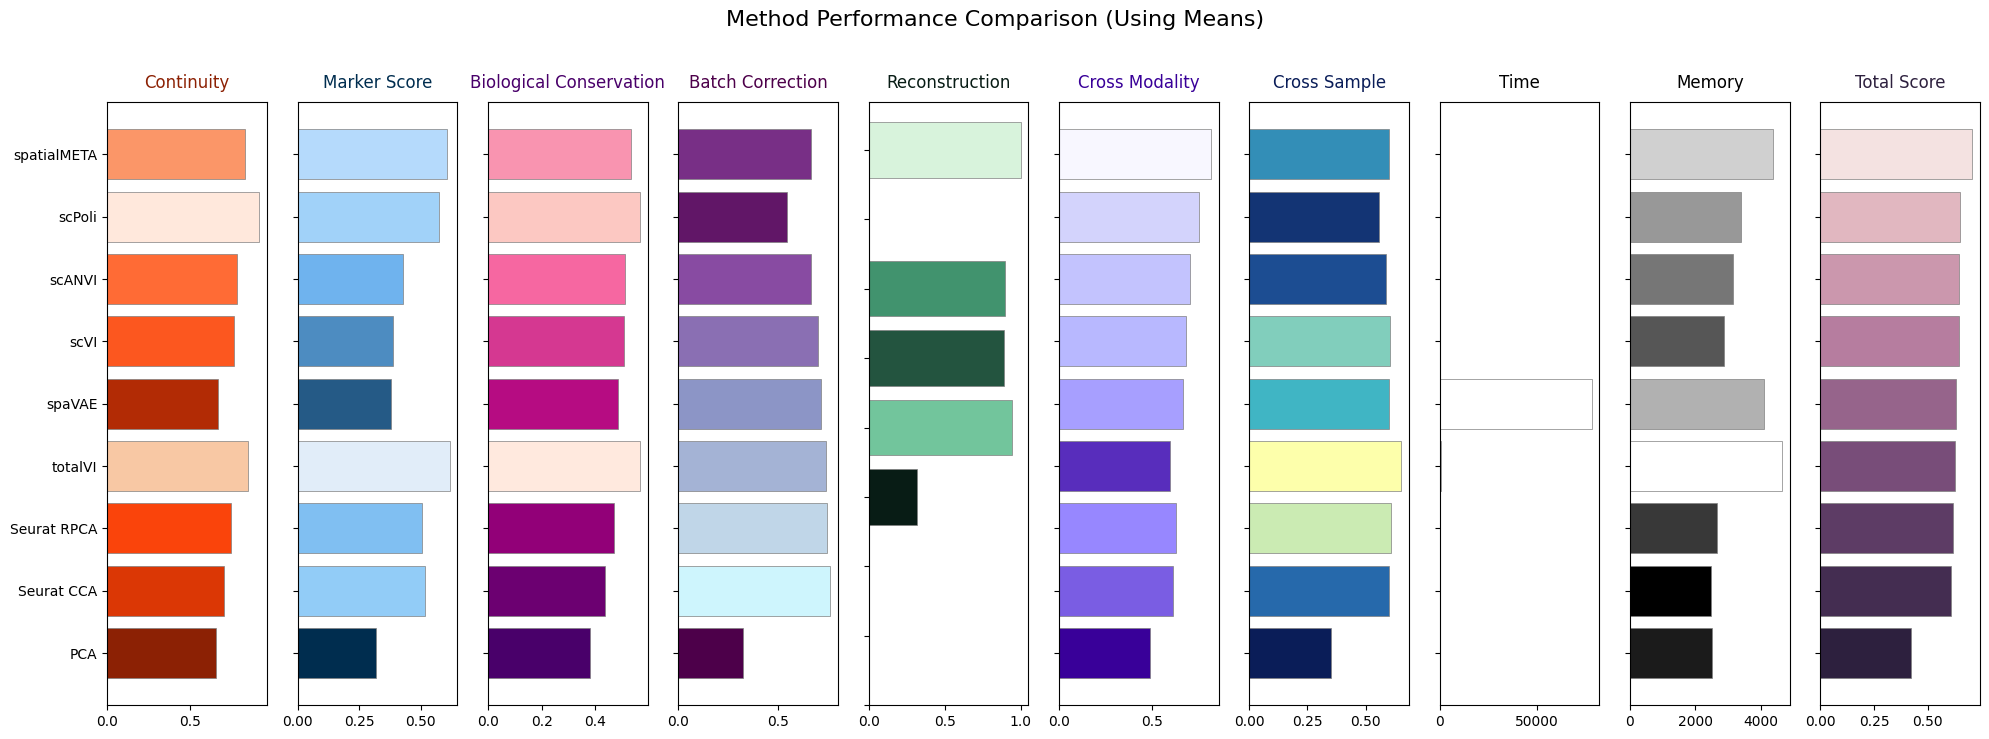

In [22]:
#df_mean['time'] = df_mean['time'].rank(ascending=False)
#df_mean['memory'] = df_mean['memory'].rank(ascending=False)
# 创建第一个图表：平均值条形图
fig1, axes1 = plt.subplots(1, 10, figsize=(20, len(methods) * 0.8))

mean_metrics = [
    ('continuity_mean', 'Continuity', create_color_map(color_dict['continuity'])),
    ('marker_score_mean', 'Marker Score', create_color_map(color_dict['marker_score'])),
    ('biological_conservation_mean', 'Biological Conservation', create_color_map(color_dict['biological_conservation'])),
    ('batch_correction_mean', 'Batch Correction', create_color_map(color_dict['batch_correction'])),
    ('reconstruction_mean', 'Reconstruction', create_color_map(color_dict['reconstruction'])),
    ('cross_modality_mean', 'Cross Modality', create_color_map(color_dict['cross_modality'])),
    ('cross_sample_mean', 'Cross Sample', create_color_map(color_dict['cross_sample'])),
    ('time', 'Time', create_color_map(color_dict['time_memory'])),
    ('memory', 'Memory', create_color_map(color_dict['time_memory'])),
    ('total_score', 'Total Score', create_color_map(color_dict['total_score']))
]

for i, (col, title, cmap) in enumerate(mean_metrics):
    values = df_mean[col]
    color_ranks = get_color_ranks(values)
    colors = [cmap(x) for x in color_ranks]

    if col == 'reconstruction_mean' and values.isnull().all():
        colors = [color_dict['reconstruction'][-1]] * len(methods)

    axes1[i].barh(
        y=range(len(methods)),
        width=values,
        color=colors,
        edgecolor='gray',
        linewidth=0.5
    )

    if col == 'time' or col == 'memory':
        axes1[i].set_title(title, fontsize=12, pad=10, color=color_dict['time_memory'][0])
    else:
        axes1[i].set_title(title, fontsize=12, pad=10, color=color_dict[col.replace('_mean', '')][0])
    axes1[i].set_yticks(range(len(methods)))
    if i == 0:
        axes1[i].set_yticklabels(methods, fontsize=10)
    else:
        axes1[i].set_yticklabels([])
    axes1[i].invert_yaxis()

plt.suptitle("Method Performance Comparison (Using Means)", fontsize=16, y=1.02)
plt.tight_layout()
fig1_path = os.path.join(output_dir, f"{sample_chosen}_means.pdf")
plt.savefig(fig1_path, bbox_inches='tight')


### dotplot

In [23]:
df_mean

,batch_asw,ilisi_graph,pcr,ARI,NMI,isolated_asw,clisi_graph,gt_silhouette,CHAOS,PAS,...,SM_specificity_mean,ST_specificity_mean,continuity_mean,marker_score_mean,biological_conservation_mean,batch_correction_mean,reconstruction_mean,cross_modality_mean,cross_sample_mean,total_score
method,,,,,,,,,,,,,,,,,,,,,
spatialMETA,0.864417,0.265464,0.870142,0.314873,0.447591,0.505073,0.907792,0.498160,0.921159,0.741500,...,0.663952,0.592603,0.831330,0.608274,0.534698,0.666674,1.000000,0.813201,0.600686,0.706944
scPoli,0.861381,0.065382,0.712511,0.371433,0.508906,0.521195,0.913113,0.514188,0.927237,0.905994,...,0.871661,0.367763,0.916615,0.576749,0.565767,0.546425,NaN,0.746682,0.556096,0.651389
scANVI,0.891604,0.324031,0.787725,0.246712,0.390920,0.519808,0.892643,0.506645,0.915016,0.651176,...,0.021944,0.289390,0.783096,0.429053,0.511346,0.667787,0.895509,0.702553,0.589566,0.646059
scVI,0.894446,0.370355,0.842282,0.224068,0.383363,0.523268,0.884906,0.512344,0.917704,0.612040,...,0.026008,0.032473,0.764872,0.389375,0.505590,0.702361,0.891427,0.681891,0.603975,0.642933
spaVAE,0.858940,0.478733,0.810720,0.187203,0.361921,0.507275,0.875604,0.496287,0.911729,0.423907,...,0.043113,0.351064,0.667818,0.381041,0.485658,0.716131,0.940102,0.662987,0.600894,0.631941
totalVI,0.907183,0.340908,0.978353,0.353287,0.505165,0.534414,0.912635,0.526240,0.918515,0.784109,...,0.846589,1.000000,0.851312,0.618233,0.566348,0.742148,0.318428,0.595991,0.654248,0.625120
Seurat RPCA,0.916874,0.381582,0.937065,0.194654,0.333922,0.485564,0.858246,0.480763,0.920248,0.571150,...,0.640194,0.063216,0.745699,0.505051,0.470630,0.745174,NaN,0.625375,0.607902,0.616638
Seurat CCA,0.918310,0.465042,0.903865,0.135020,0.281045,0.473375,0.823379,0.466775,0.917030,0.495752,...,0.836757,0.462778,0.706391,0.517511,0.435919,0.762406,NaN,0.611951,0.599162,0.605557
PCA,0.833836,0.133533,0.000000,0.095045,0.207092,0.417844,0.774546,0.406650,0.914611,0.401645,...,0.371060,0.012126,0.658128,0.319564,0.380235,0.322457,NaN,0.488846,0.351346,0.420096


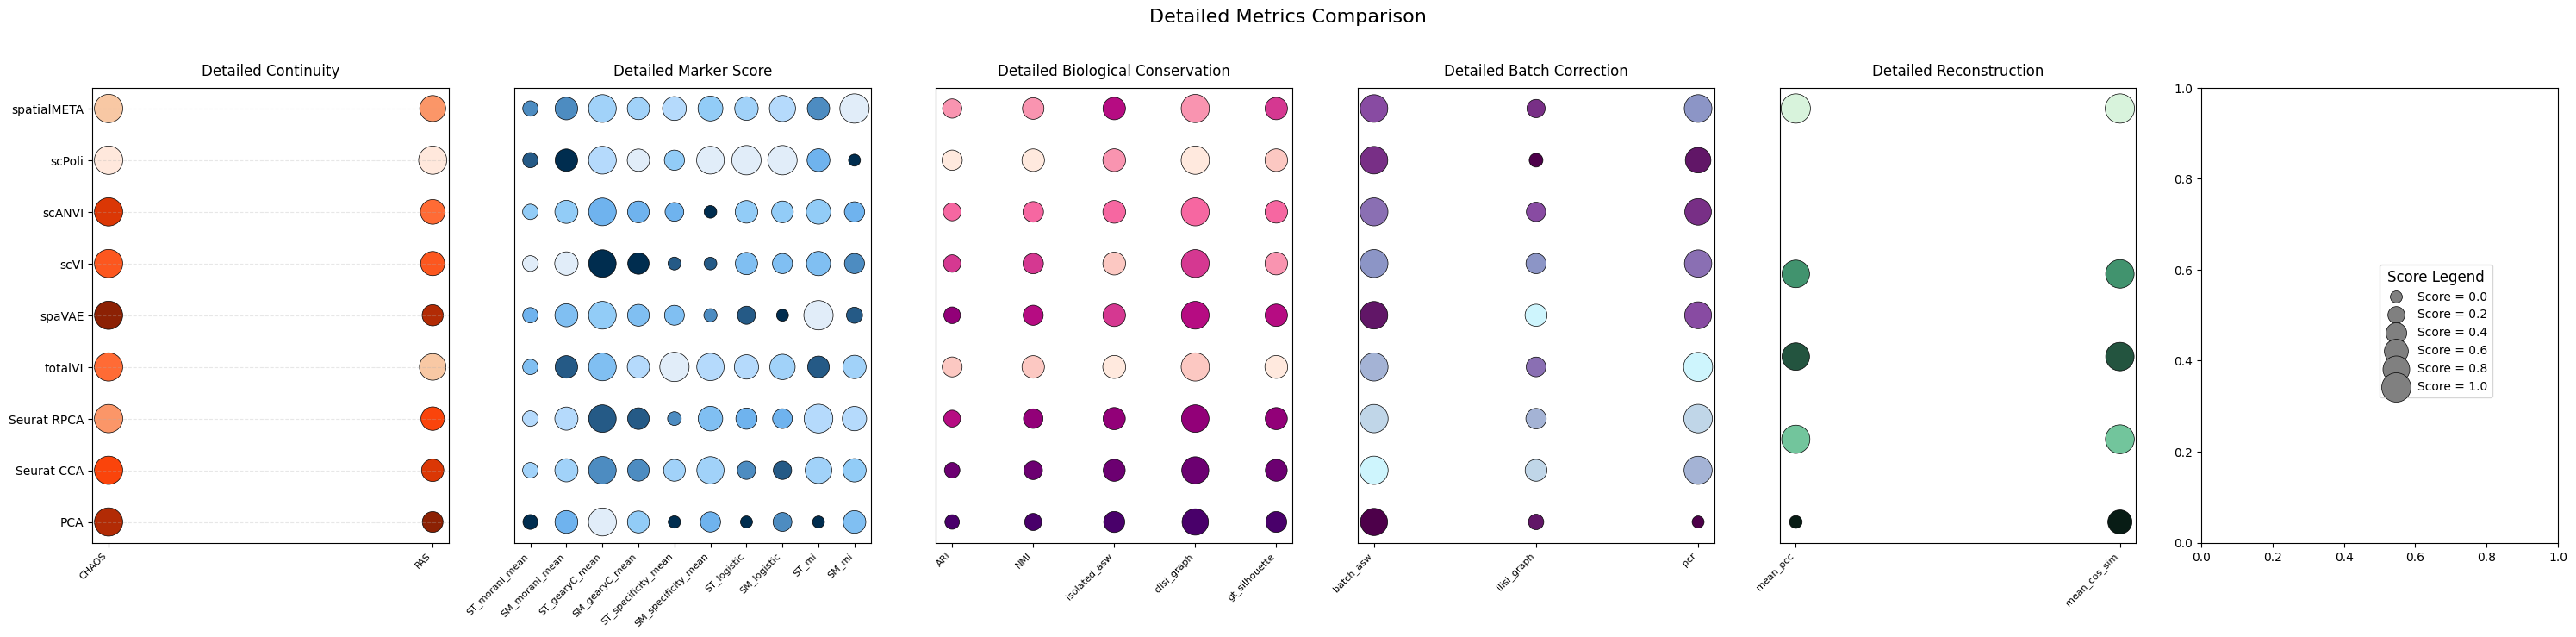

In [24]:
# 创建第二个图表：详细指标散点图
fig2, axes2 = plt.subplots(1, 6, figsize=(30, len(methods) * 0.8))

metric_groups = [
    ('Continuity', continuity_metrics, color_dict['continuity']),
    ('Marker Score', marker_score_metrics, color_dict['marker_score']),
    ('Biological Conservation', biological_conservation_metrics, color_dict['biological_conservation']),
    ('Batch Correction', batch_correction_metrics, color_dict['batch_correction']),
    ('Reconstruction', reconstruction_metrics, color_dict['reconstruction'])
]

# 定义图例的值和对应的大小
score_values = [0, 0.2, 0.4, 0.6, 0.8, 1.0]  # 图例显示的分数值
size_scale = np.array([100, 200, 300, 400, 500, 600])  # 对应的点大小

# 创建一个额外的轴用于放置图例
legend_ax = fig2.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
legend_ax.axis('off')

# 创建图例的代理对象
legend_elements = [plt.scatter([], [], s=size, c='gray', 
                             edgecolor='black', lw=0.5,
                             label=f'Score = {value:.1f}')
                  for size, value in zip(size_scale, score_values)]

# 添加图例
legend = legend_ax.legend(handles=legend_elements, 
                         title='Score Legend',
                         loc='center left',
                         frameon=True,
                         fontsize=10)
legend.get_title().set_fontsize(12)

for i, (group_name, metrics, colors) in enumerate(metric_groups):
    ax = axes2[i]
    
    for j, metric in enumerate(metrics):
        values = df_mean[metric]
        color_ranks = get_color_ranks(values)
        cmap = create_color_map(colors)
        point_colors = [cmap(x) for x in color_ranks]

        if group_name == 'Reconstruction' and values.sum() == 0:
            point_colors = [colors[-1]] * len(methods)

        # 将值映射到定义的大小范围
        sizes = np.interp(values, [0, 1], [size_scale[0], size_scale[-1]])

        ax.scatter(
            x=[j] * len(methods),
            y=range(len(methods)),
            s=sizes,  # 使用映射后的大小
            c=point_colors,
            edgecolor='black', 
            lw=0.5
        )

    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(metrics, rotation=45, ha='right', fontsize=8)
    ax.set_title(f'Detailed {group_name}', fontsize=12, pad=10)
    ax.invert_yaxis()
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    if i == 0:
        ax.set_yticks(range(len(methods)))
        ax.set_yticklabels(methods, fontsize=10)
    else:
        ax.set_yticks([])

plt.suptitle("Detailed Metrics Comparison", fontsize=16, y=1.02)
plt.tight_layout()
fig2_path = os.path.join(output_dir, f"{sample_chosen}_detailed.pdf")
plt.savefig(fig2_path, bbox_inches='tight')


### barplot （time and memory rank）

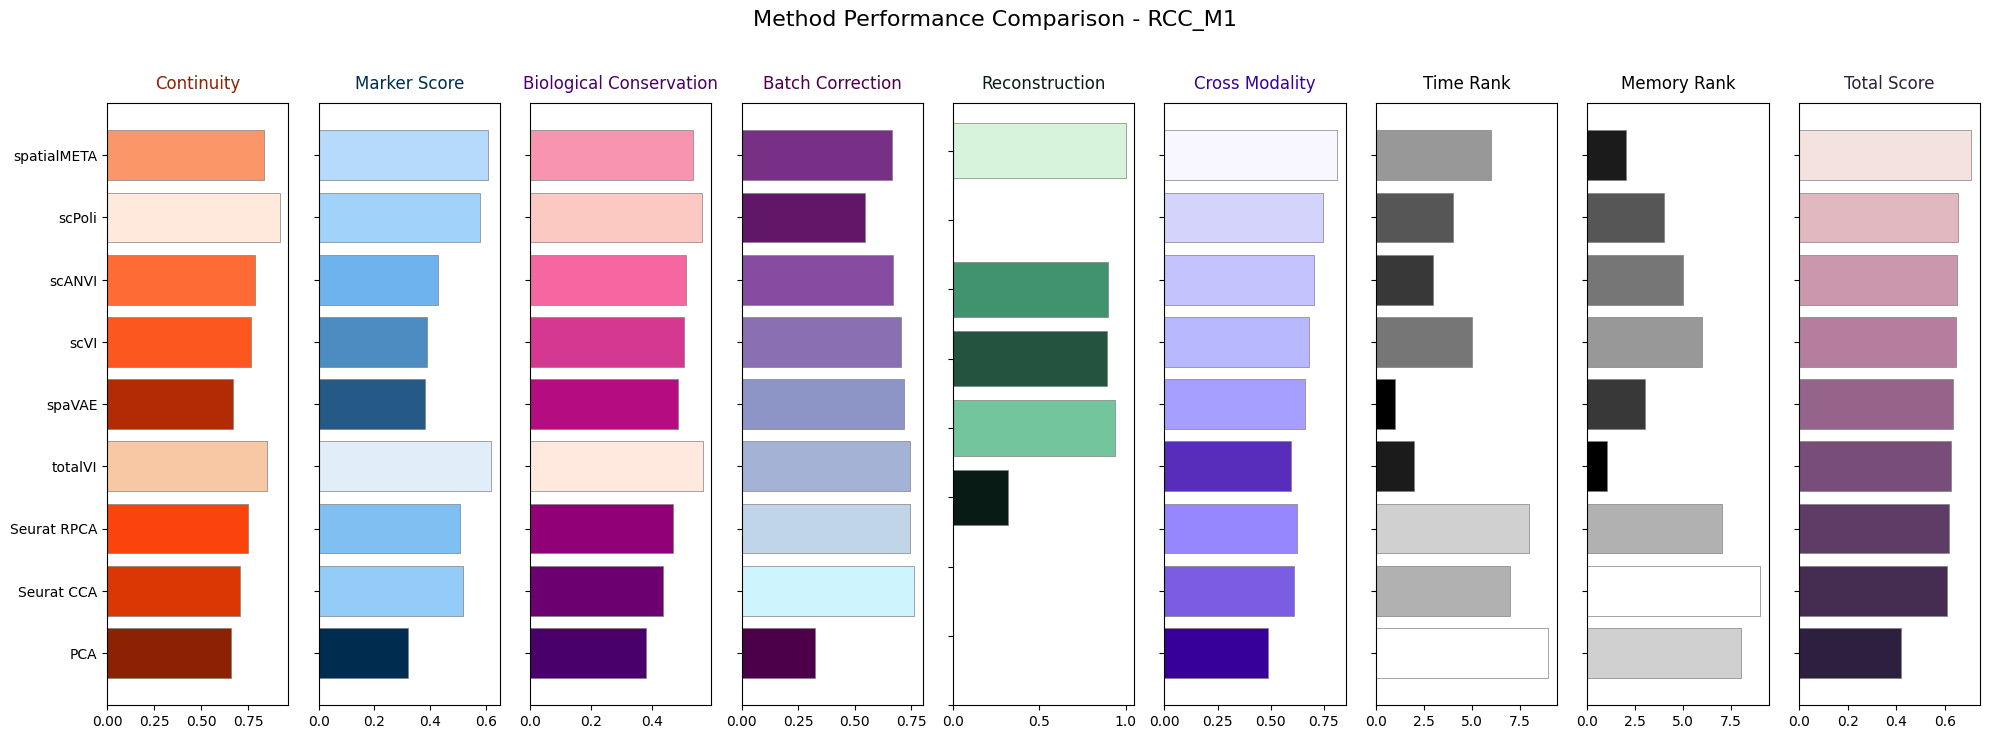

Performance comparison chart saved as RCC_M1_performance_comparison.pdf


In [25]:
# Prepare data for visualization
methods = df_mean.index

# Convert time and memory to ranks for better visualization
if 'time' in df_mean.columns:
    df_mean['time_display'] = df_mean['time'].rank(ascending=False)
if 'memory' in df_mean.columns:
    df_mean['memory_display'] = df_mean['memory'].rank(ascending=False)

# Create the main performance comparison chart
fig1, axes1 = plt.subplots(1, 9, figsize=(20, len(methods) * 0.8))

mean_metrics = [
    ('continuity_mean', 'Continuity', create_color_map(color_dict['continuity'])),
    ('marker_score_mean', 'Marker Score', create_color_map(color_dict['marker_score'])),
    ('biological_conservation_mean', 'Biological Conservation', create_color_map(color_dict['biological_conservation'])),
    ('batch_correction_mean', 'Batch Correction', create_color_map(color_dict['batch_correction'])),
    ('reconstruction_mean', 'Reconstruction', create_color_map(color_dict['reconstruction'])),
    ('cross_modality_mean', 'Cross Modality', create_color_map(color_dict['cross_modality'])),
    #('cross_sample_mean', 'Cross Sample', create_color_map(color_dict['cross_sample'])),
    ('time_display', 'Time Rank', create_color_map(color_dict['time_memory'])),
    ('memory_display', 'Memory Rank', create_color_map(color_dict['time_memory'])),
    ('total_score', 'Total Score', create_color_map(color_dict['total_score']))
]

for i, (col, title, cmap) in enumerate(mean_metrics):
    if col not in df_mean.columns:
        continue
        
    values = df_mean[col]
    color_ranks = get_color_ranks(values)
    colors = [cmap(x) for x in color_ranks]

    # Handle special cases
    if col == 'reconstruction_mean' and values.sum() == 0:
        colors = [color_dict['reconstruction'][-1]] * len(methods)

    axes1[i].barh(
        y=range(len(methods)),
        width=values,
        color=colors,
        edgecolor='gray',
        linewidth=0.5
    )

    # Set title colors
    if 'time' in col or 'memory' in col:
        title_color = color_dict['time_memory'][0]
    else:
        metric_key = col.replace('_mean', '').replace('_display', '')
        title_color = color_dict.get(metric_key, '#000000')[0]
    
    axes1[i].set_title(title, fontsize=12, pad=10, color=title_color)
    axes1[i].set_yticks(range(len(methods)))
    
    if i == 0:
        axes1[i].set_yticklabels(methods, fontsize=10)
    else:
        axes1[i].set_yticklabels([])
    
    axes1[i].invert_yaxis()

plt.suptitle(f"Method Performance Comparison - {sample_chosen.upper()}", fontsize=16, y=1.02)
plt.tight_layout()
fig_performance_path = os.path.join(output_dir, f"{sample_chosen}_performance_comparison.pdf")
plt.savefig(fig_performance_path, bbox_inches='tight')
plt.show()

print(f"Performance comparison chart saved as {sample_chosen}_performance_comparison.pdf")

## boxplot

In [26]:
df = pd.read_csv(f"/mnt/volume0/cyr_qyc/qyc/cross_sample/results_new/benchmark/index/{sample_chosen}_sample_norm.csv")
df_bysample = pd.read_csv(f"/mnt/volume0/cyr_qyc/qyc/cross_sample/results_new/benchmark/index/merge_adata_{sample_chosen}_svf_bench_sample.csv")

In [27]:
output_dir = "/mnt/volume0/cyr_qyc/qyc/cross_sample/results_new/visualization_0611"

In [28]:
def convert_to_long_format(df):
    # 去掉前四列
    df = df.iloc[:, 4:]
    
    # 获取所有列名
    all_cols = df.columns.tolist()
    
    # 找出所有带样本前缀的指标
    sample_metrics = {}
    for col in all_cols:
        if '_' in col and col != 'method':
            parts = col.split('_')
            if len(parts) >= 3:  # 至少3部分 (如 m1_FMP_ARI)
                sample = '_'.join(parts[:2])  # 获取样本名 (如 m1_FMP)
                metric_name = '_'.join(parts[2:])  # 获取指标名 (如 ARI)
                if metric_name not in sample_metrics:
                    sample_metrics[metric_name] = []
                sample_metrics[metric_name].append((col, sample))
    
    # 创建新的DataFrame
    result_data = []
    for _, row in df.iterrows():
        method = row['method']
        # 对每个样本创建一个字典
        sample_dicts = {}
        for metric_name, cols_samples in sample_metrics.items():
            for col, sample in cols_samples:
                if sample not in sample_dicts:
                    sample_dicts[sample] = {'method': method, 'sample': sample}
                sample_dicts[sample][metric_name] = row[col]
        result_data.extend(sample_dicts.values())
    
    # 转换为DataFrame并重新排序列
    result_df = pd.DataFrame(result_data)
    metric_cols = sorted([col for col in result_df.columns if col not in ['method', 'sample']])
    result_df = result_df[['method', 'sample'] + metric_cols]
    
    return result_df
df_bysample_long = convert_to_long_format(df_bysample)

In [29]:
df_bysample_long = calculate_mean_metrics(df_bysample_long)

In [30]:
df_bysample_long.method = df_bysample_long.method.replace(convert_dict)

In [31]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [32]:
exclude_cols = ['method', 'file_name', 'leiden_clusters', 'sample','cell_count','ASW']
metrics = [col for col in df_bysample_long.columns if col not in exclude_cols]
n_metrics = len(metrics)
n_cols = 3  
n_rows = (n_metrics + n_cols - 1) // n_cols

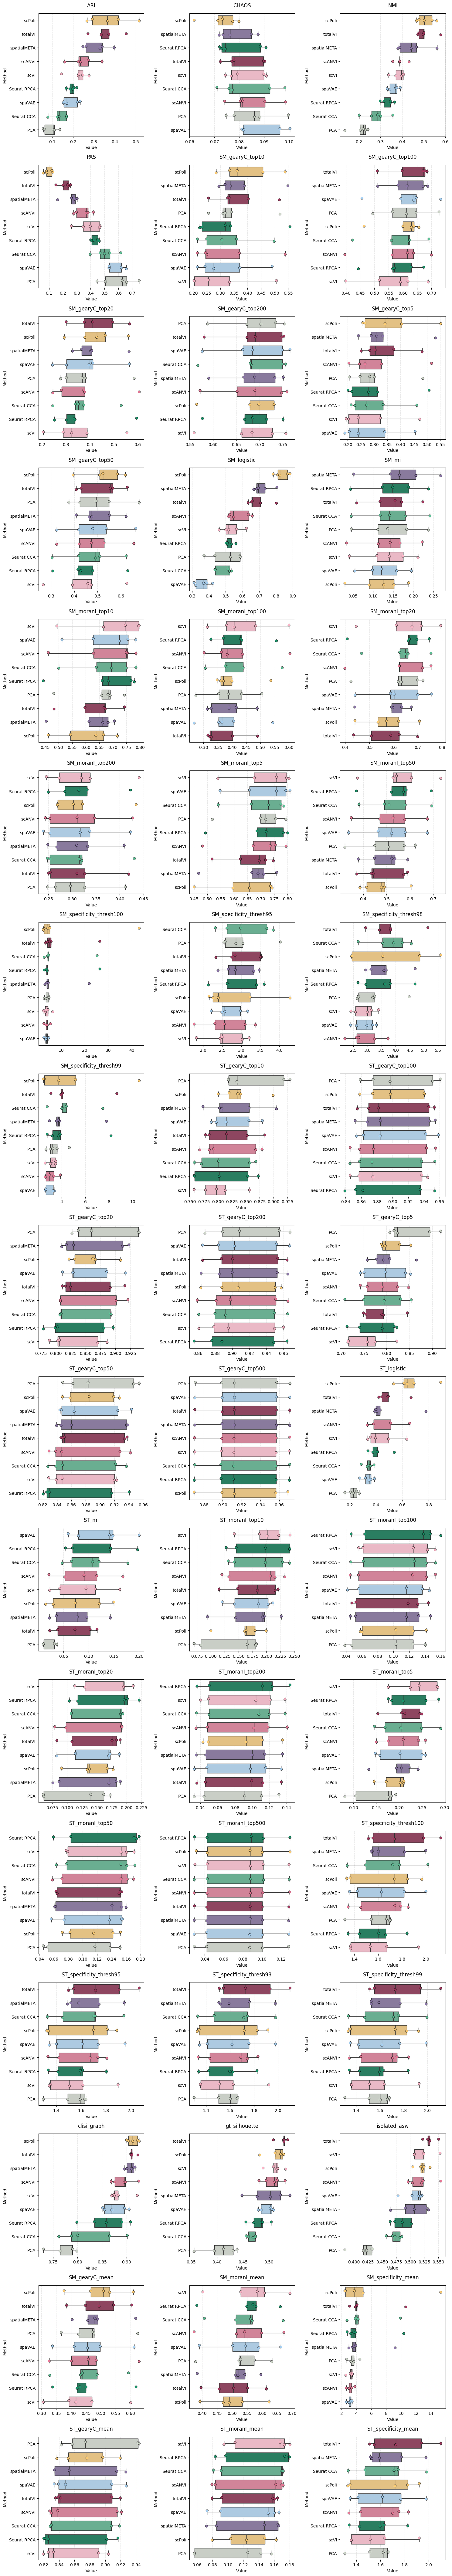

In [33]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()


for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    ascending = True if metric in ['CHAOS', 'PAS'] else False

    method_means = df_bysample_long.groupby('method')[metric].mean()
    method_order = method_means.sort_values(ascending=ascending).index
    
    sns.boxplot(data=df_bysample_long, 
                x=metric, 
                y='method',
                order=method_order,
                palette=method_color_dict,
                width=0.7,
                saturation=0.7,
                ax=ax,
                showfliers=False)
    
    sns.stripplot(data=df_bysample_long,  
               x=metric,  
               y='method',  
               order=method_order,  
               hue='method',  # Specify hue for color mapping  
               palette=method_color_dict,  # Set palette to color_dict  
               size=6,  
               alpha=1,  
               jitter=True,  
               ax=ax,
               edgecolor='black',  # Add white edge color for better visibility  
               linewidth=0.5)  
    
    ax.set_title(metric, fontsize=12, pad=15)
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Method', fontsize=10)
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)

for idx in range(n_metrics, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
save_path = os.path.join(output_dir, f"{sample_chosen}_boxplot.pdf")
plt.savefig(save_path, bbox_inches='tight')

## Barplot for batch, time, memory and reconstruction

In [34]:
df.method = df.method.replace(convert_dict)

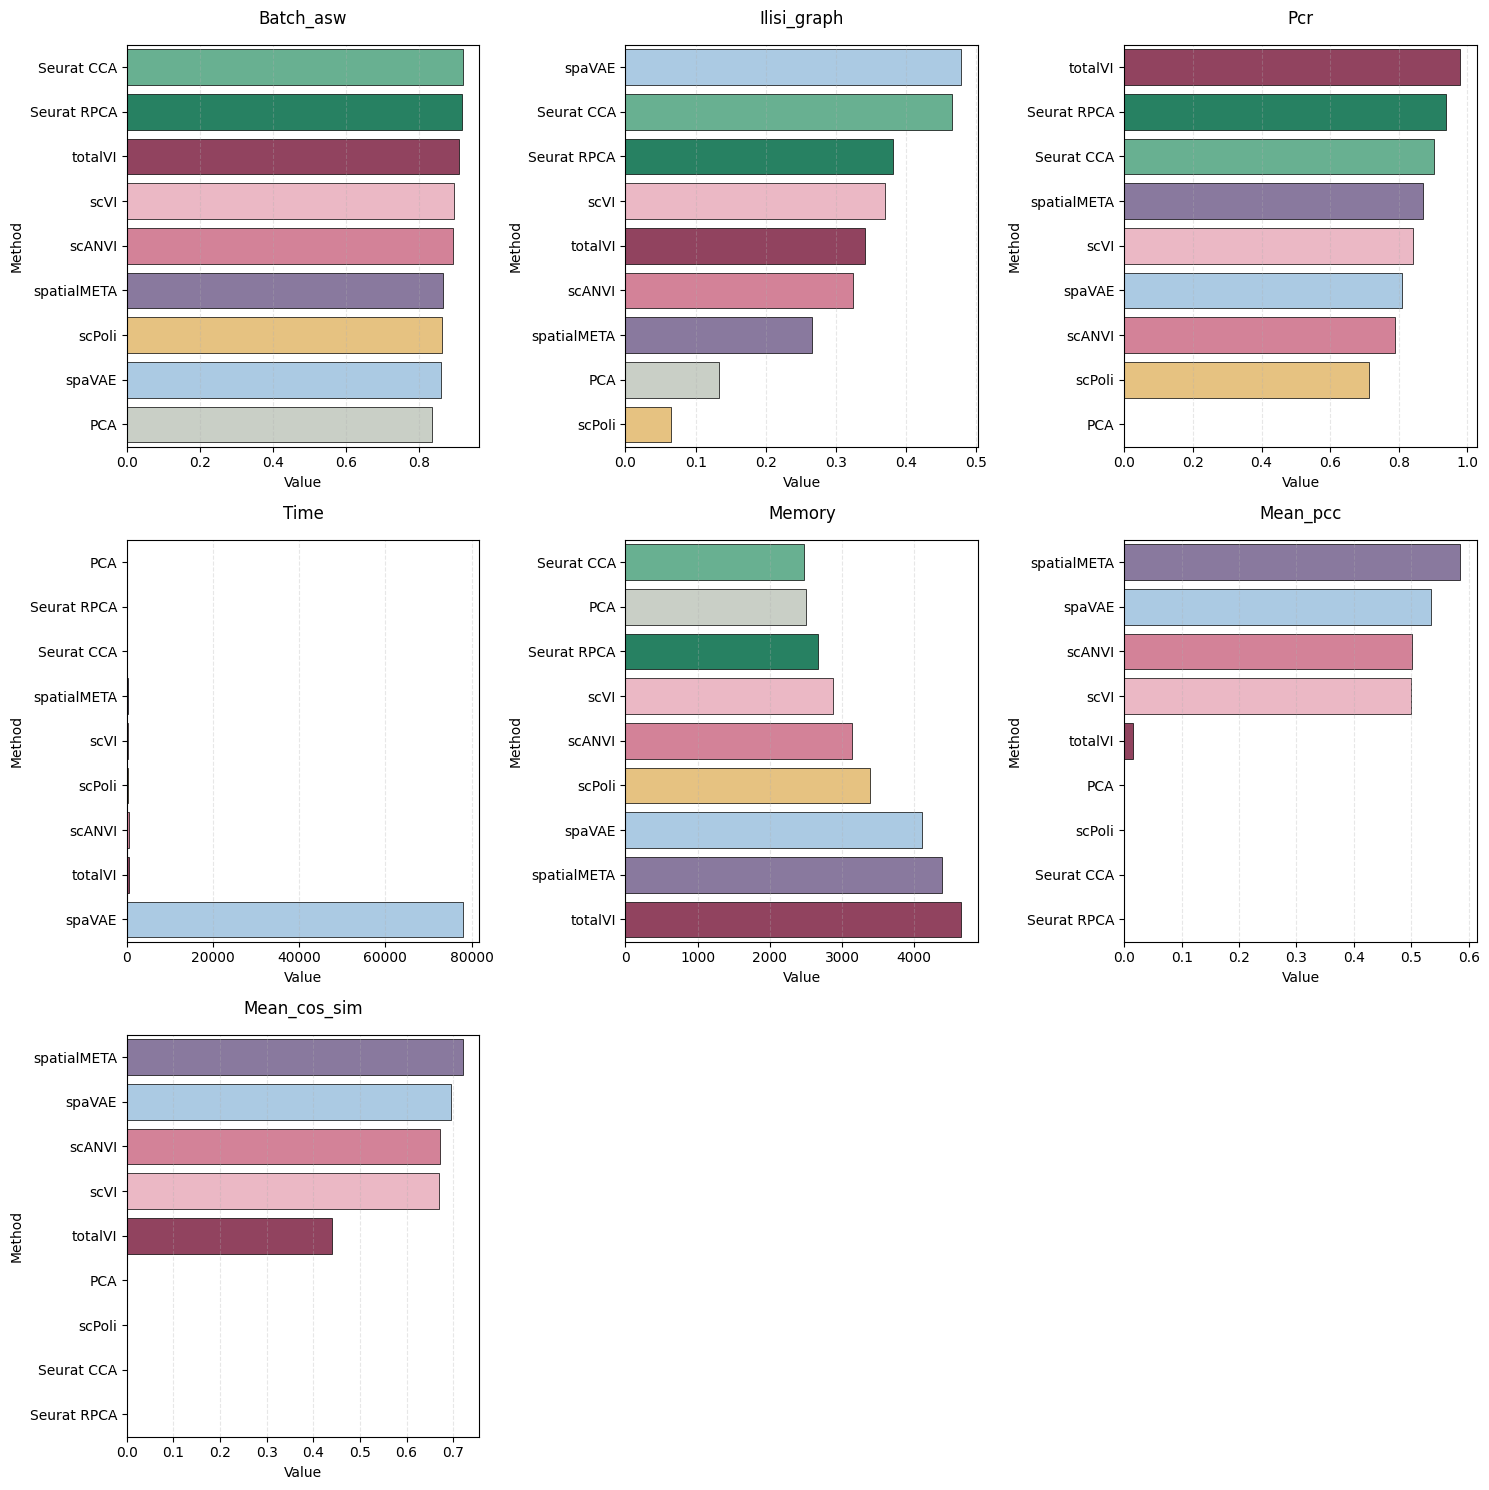

In [35]:
include_cols = ['batch_asw', 'ilisi_graph', 'pcr', 'time', 'memory', 'mean_pcc', 'mean_cos_sim']
metrics = [col for col in df.columns if col in include_cols]
n_metrics = len(metrics)
n_cols = 3  
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]  
    
    ascending = True if metric in ['time', 'memory'] else False
    ordered_df = df.sort_values(by=metric, ascending=ascending)
    method_order = ordered_df['method'].tolist()
    
    sns.barplot(data=df,   
                x=metric,   
                y='method',  
                order=method_order,  
                palette=method_color_dict,  
                ax=ax,  
                ci=None,  
                capsize=0.1,  
                errcolor='gray')  
    
    for patch in ax.patches:  
        patch.set_edgecolor('black')
        patch.set_linewidth(0.5)

    ax.set_title(metric.capitalize(), fontsize=12, pad=15)  
    ax.set_xlabel('Value', fontsize=10)  
    ax.set_ylabel('Method', fontsize=10)  
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)  

for idx in range(n_metrics, len(axes)):  
    fig.delaxes(axes[idx])  

plt.tight_layout()
plt.savefig(os.path.join(output_dir,f"{sample_chosen}_barplots.pdf"))